In [9]:
import torch
import pprint as pp
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np
from operator import add
import matplotlib.pyplot as plt

In [2]:
# hyperparameters

batch_size = 64
num_caps = 10
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5
torch.backends.cudnn.enabled = False

In [3]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.1307,), (0.3081,))
              #torchvision.transforms.RandomRotation(20)
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
import torch.nn as nn

In [7]:
nn.Sequential(
    nn.Linear(10, 20),
#     nn.ReLU(True),
    nn.Conv2d(20, 30, 1)
)


Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=30, bias=True)
)

$$
W_{30\times20} \times g(W_{20\times10} \times x_{10}) 
\neq (W_{30\times20} \times W_{20\times10}) \times x_{10} 
= W_{30\times 10} \times x_{10}
$$

In [12]:
x = torch.randn(32, 100)

class Linear(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.randn(100, 50))
        self.b = nn.Parameter(torch.randn(50,))
        
    def forward(self, x):
        return x @ self.W + self.b.view(1, -1)

In [ ]:
nn.BatchNorm2d()

In [22]:
class BN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.randn(32))
        self.bias = nn.Parameter(torch.randn(32))
        
    def forward(self, x):
        mean_ = ...
        x = x - mean_
        x = x + self.bias
#         x = x / x.std(0)
#         x = x * self.scale + self.bias
        return x

SyntaxError: invalid syntax (<ipython-input-22-0a7e4c934dcf>, line 1)

In [15]:
layer = Linear()

In [21]:
x_new = [x_ @ layer.W + layer.b for x_ in x]
x_new[0]

tensor([ -6.4691,  12.2545, -23.9756,  12.7195,   4.8907,  -5.8851,  -5.2553,
         19.7081,   4.8938,  -9.4599, -16.4893,  26.3831,  -2.9603,  12.6582,
         -6.8421,  -5.8176, -10.4351,  -7.6276,   1.5216,  16.4991,   8.0549,
          3.0383,   0.3285,  -1.4406,  18.8055, -10.5692,  -2.5636,  -3.6881,
          1.5974, -10.4553,  13.4954, -12.0461,   6.5573, -16.7608,  10.9004,
         -6.8145,   7.1806,   8.9476,  -5.8113, -11.1367,   3.4129, -14.4839,
         -5.0055,   2.2107,   1.9320,   8.1723,  -1.9597,  -1.5749,  -1.5414,
         -2.7629], grad_fn=<AddBackward0>)

In [5]:
def shift_image(image):
    dx = np.random.randint(-3, 4)
    dy = np.random.randint(-3, 4)
    image = torch.roll(image, dx, -1)
    image = torch.roll(image, dy, -2)
    return image, dx, dy

In [6]:
class Capsule(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 14
            
            nn.Conv2d(16, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 7
        )
    
        self.lin = nn.Sequential(
            nn.Linear(8, 3),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 64, 3, stride=2, padding=1, bias=False, output_padding=1), # B, 8, 14, 14
            nn.BatchNorm2d(2), 
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, bias=True, output_padding=1), # B, 1, 28, 28  
            nn.Sigmoid()
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 4*49), 
            nn.ReLU(True)
#             nn.Sigmoid()
        )

        self.sig = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder(x)
        x = x.mean(-1).mean(-1)
        z = self.lin(x)
        p = z[:,[0]]
        p = self.sig(p)
        xy = z[:,[1,2]]
        return p, xy
    
    
    def decode(self, xy):
        xy = self.decoder_lin(xy)
        xy = torch.reshape(xy, (64, 4 ,7 , 7))
        return self.decoder(xy)
    
capsule = Capsule().to(device)

In [7]:
class TAE(nn.Module):
    def __init__(self, num_caps=num_caps):
        super().__init__()
        self.caps = nn.ModuleList([
            Capsule().to(device) for _ in range(num_caps) 
        ])
    
    def forward(self, img, dx_dy):
        output_image = 0.0
        for caps in self.caps:
            p_list, xy_list = caps.encode(img)
            xy_shifted = xy_list + dx_dy
            #xy_shifted = torch.stack(xy_shifted)
            img_rec = caps.decode(xy_shifted)
            img_rec = img_rec * p_list[:, :, None, None]
            output_image = output_image + img_rec

        return output_image
    
    

model = TAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

TAE(
  (caps): ModuleList(
    (0): Capsule(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (lin): Sequential(
        (0): Linear(in_features=8, out_features=3, bias=True)
      )
      (decoder): Sequential(
        (0): ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
        (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, tr

In [8]:
# shifts = [
#             [-2, -2], [-2, -1], [-2, 0], [-2, 1], [-2, 2],
#             [-1, -2], [-1, -1], [-1, 0], [-1, 1], [-1, 2],
#             [0, -2], [0, -1], [0, 0], [0, 1], [0, 2],
#             [1, -2], [1, -1], [1, 0], [1, 1], [1, 2],
#             [2, -2], [2, -1], [2, 0], [2, 1], [2, 2]
#         ]

shifts = (np.indices([5, 5]) - 2).reshape(2, -1).T

In [9]:
def train(train_loader):
    model.train()
    loss = 0
    criterion = nn.MSELoss().to(device)
    
    for batch_features, target in train_loader:

        batch_features, target = batch_features.to(device), target.to(device)
        new_features, dx, dy = shift_image(batch_features)

        optimizer.zero_grad()

        output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))

        # compute training reconstruction loss
        train_loss = criterion(output_image, new_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss = loss + train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epochs + 1, epochs, loss))
    return output_image, batch_features

def test(test_loader):
    model.eval()
    outputs = []
    for batch_features, target in test_loader:
        batch_features, target = batch_features.to(device), target.to(device)
        
        for dx, dy in shifts:
#             rolled_image = torch.roll(batch_features, dx, -1)
#             rolled_image = torch.roll(rolled_image, dy, -2)
#             new_features, dx, dy = shift_image(rolled_image)
            output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))
            outputs.append(output_image)

        return outputs, target[0]

In [10]:
torch.autograd.set_detect_anomaly(True)

epochs = 20
outputs = []  
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    output, _ = train(train_dataloader)
    outputs.append(output)
shift_grid = test(test_dataloader)

print("Finished")

Epoch 1
-------------------------------
epoch : 21/20, loss = 0.649009
Epoch 2
-------------------------------
epoch : 21/20, loss = 0.550078
Epoch 3
-------------------------------
epoch : 21/20, loss = 0.513267
Epoch 4
-------------------------------
epoch : 21/20, loss = 0.492977
Epoch 5
-------------------------------
epoch : 21/20, loss = 0.479471
Epoch 6
-------------------------------
epoch : 21/20, loss = 0.468172
Epoch 7
-------------------------------
epoch : 21/20, loss = 0.460402
Epoch 8
-------------------------------
epoch : 21/20, loss = 0.453590
Epoch 9
-------------------------------
epoch : 21/20, loss = 0.448155
Epoch 10
-------------------------------
epoch : 21/20, loss = 0.443055
Epoch 11
-------------------------------
epoch : 21/20, loss = 0.436047
Epoch 12
-------------------------------
epoch : 21/20, loss = 0.432605
Epoch 13
-------------------------------
epoch : 21/20, loss = 0.428555
Epoch 14
-------------------------------
epoch : 21/20, loss = 0.425561
E

In [11]:
# for k in range(0, epochs, 4): 
#     plt.figure(figsize=(9, 2))
#     plt.gray()
#     imgs = outputs[k].detach().cpu().numpy()
#     for i, item in enumerate(imgs):
#         if i >= 9: break
#         plt.subplot(2,9, i+1)
#         plt.imshow(item[0])

#     for i, item in enumerate(recon):
#         if i >= 9: break
#         plt.subplot(2, 9, 9+i+1)
#         plt.imshow(item)



tensor(9, device='cuda:0')
tensor(5, device='cuda:0')
tensor(1, device='cuda:0')
tensor(5, device='cuda:0')
tensor(1, device='cuda:0')


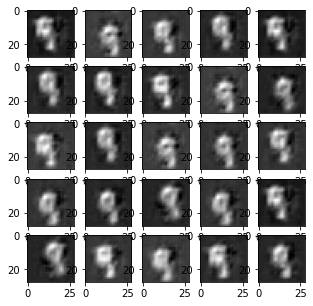

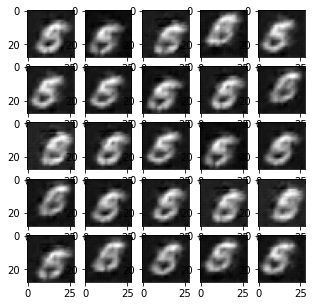

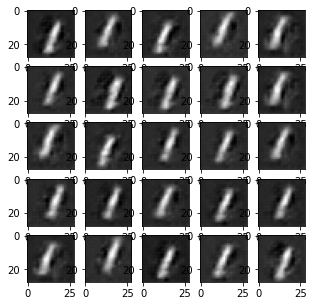

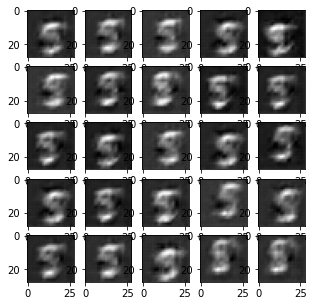

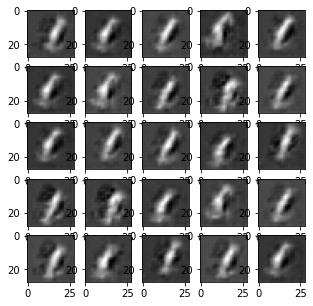

In [12]:
for _ in range(5):
  shift_grid, target = test(test_dataloader)
  print(target)
  plt.figure(figsize=(5, 5))
  plt.gray()
  for i, item in enumerate(shift_grid):
      item = item.detach().cpu().numpy()
      if i >= 25: break
      plt.subplot(5,5, i+1)
      plt.imshow(item[0][0])
